In [1]:
!git clone https://github.com/amirshane/ProtMIMO-CodingChallenge.git

fatal: destination path 'ProtMIMO-CodingChallenge' already exists and is not an empty directory.


In [2]:
import os
os.chdir('/content/ProtMIMO-CodingChallenge')
!pip3 install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ProtMIMO-CodingChallenge
  Attempting uninstall: ProtMIMO
    Found existing installation: ProtMIMO 1.0
    Can't uninstall 'ProtMIMO'. No files were found to uninstall.
  Running setup.py develop for ProtMIMO


In [3]:
os.chdir('ProtMIMO')

In [4]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy.stats import spearmanr 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from data_utils import *
%matplotlib inline

# Analyze data

First, I looked at the histograms of log fluorescence and number of mutations for training, validation, and test set. I found

(1) All the three dataset has a bimodal distribution of fluorescence, suggesting two group of different mutations either enhance or decrease the fluoresence.

(2) All the data in train and validation has mutation numbers < 4, while all testing data have mutation numbers >=4. More data points in train/val have high fluorescence, while less data points in testing have low fluorescence.

(3) From (2), it can be concluded that the train and validation data seem to be sampled from one distribution, which is expected. Testing data is from another distribution. 

(4) From (3) it should be noticed that the overfitting problem should be concerned.

In [5]:
train_df, val_df, test_df = get_gfp_dfs()

(0, 4)

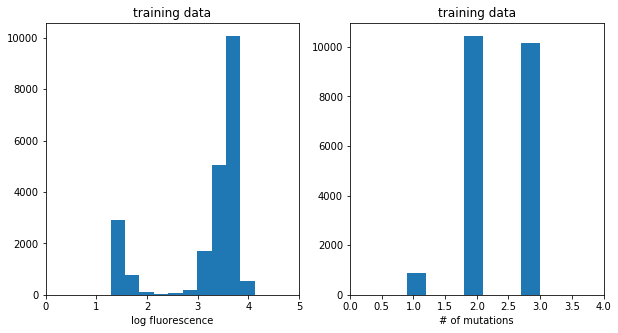

In [6]:
train_log_f = list(train_df['log_fluorescence'])
train_n_mut = list(train_df['num_mutations'])

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('training data')
hist1 = plt.hist(train_log_f)
plt.xlabel('log fluorescence')
plt.xlim([0,5])
plt.subplot(122)
plt.title('training data')
hist2 = plt.hist(train_n_mut)
plt.xlabel('# of mutations')
plt.xlim([0,4])

(0, 4)

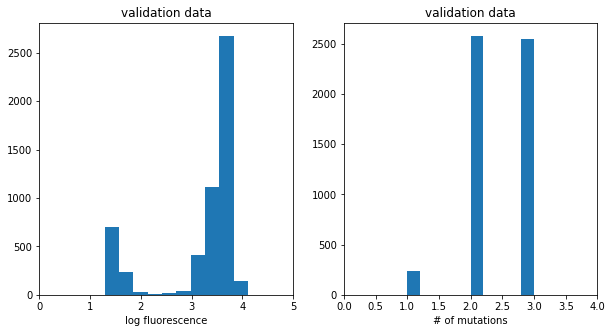

In [7]:
val_log_f = list(val_df['log_fluorescence'])
val_n_mut = list(val_df['num_mutations'])
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('validation data')
hist1 = plt.hist(val_log_f)
plt.xlabel('log fluorescence')
plt.xlim([0,5])
plt.subplot(122)
plt.title('validation data')
hist2 = plt.hist(val_n_mut)
plt.xlabel('# of mutations')
plt.xlim([0,4])

(0, 15)

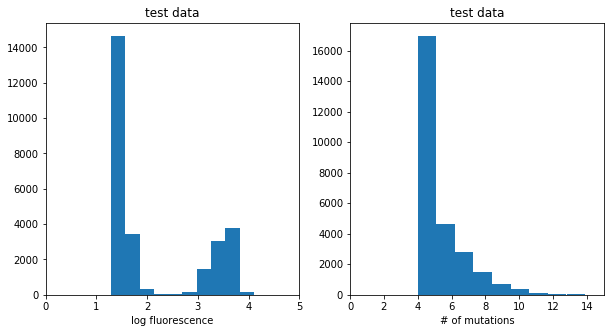

In [8]:
test_log_f = list(test_df['log_fluorescence'])
test_n_mut = list(test_df['num_mutations'])

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('test data')
hist1 = plt.hist(test_log_f)
plt.xlabel('log fluorescence')
plt.xlim([0,5])
plt.subplot(122)
plt.title('test data')
hist2 = plt.hist(test_n_mut)
plt.xlabel('# of mutations')
plt.xlim([0,15])

# Pad data
Since not all the primary sequences have length of 237, I padded the data to make all data the same length. Here I just append '.' symbol to the end of the sequences whose length < 237. A more rigourous way is to find where the deletion was and use a '.' to mark the deletion. Since only a small fraction (2% in training/val, 6% in testing) has lenght < 237, such simplified padding should be fine. 

In the training data there is one sequence has zero mutation. This should be the wilde type.

In [9]:
frac_train = np.sum(train_df['protein_length']<237) / len(train_df)
frac_test = np.sum(test_df['protein_length']<237) / len(test_df)
print('Sequence with deletions in training has a fraction of ', np.round(frac_train*100,2), '%')
print('Sequence with deletions in test has a fraction of ', np.round(frac_test*100,2), '%')

Sequence with deletions in training has a fraction of  2.25 %
Sequence with deletions in test has a fraction of  6.25 %


In [10]:
original_seq = train_df[train_df['num_mutations']==0]['primary'].values
print(original_seq)

['SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK']


In [11]:
def convert_seq_to_label(x, dic):
    y = [dic[i] for i in x]
    if(len(y)!=237):
        y = y + (237-len(y)) * [dic['.']]
    return y

In [12]:
train_seq_label = []
for i,x in train_df.iterrows():
    train_seq_label.append(convert_seq_to_label(x['primary'], GFP_ALPHABET))
train_y = list(train_df['log_fluorescence'])

val_seq_label = []
for i,x in val_df.iterrows():
    val_seq_label.append(convert_seq_to_label(x['primary'], GFP_ALPHABET))
val_y = list(val_df['log_fluorescence'])

test_seq_label = []
for i,x in test_df.iterrows():
    test_seq_label.append(convert_seq_to_label(x['primary'], GFP_ALPHABET))
test_y = list(test_df['log_fluorescence'])

# Linear regression
First I performed a linear regression which sets a level for the deep learning model to compare with. For each of the sequence, I treated it as a 237-dimensional vector, each element being a integer ranging from 0-20 to represent 20 amino acids (+1 "." symbol). Then I did a linear regression for the training data and tested the model on the testing data. Since each datapoint has 237 dimensions, the total number of parameters is 237+1 (interception). 

We found the mse of linear regression on the training set is 0.41. However, on the test dataset, the model prediciton mse is 1.27, even larger than the mse of the test set. Note that a model whose prediction mse is larger than the std is no better than a random guess. 

In [13]:
model_linear = LinearRegression().fit(np.array(train_seq_label), np.array(train_y))
y_train_linear_pred = model_linear.predict(train_seq_label)
train_mse = mean_squared_error(y_true = train_y, y_pred=y_train_linear_pred)
train_pearson, _ = pearsonr(train_y, y_train_linear_pred)
train_spearmanr = spearmanr(train_y, y_train_linear_pred).correlation

y_test_linear_pred = model_linear.predict(test_seq_label)
test_mse = mean_squared_error(y_true = test_y, y_pred=y_test_linear_pred)
test_pearson, _ = pearsonr(test_y, y_test_linear_pred)
test_spearmanr = spearmanr(test_y, y_test_linear_pred).correlation

print('training data: mse, pearson correltion, Spearman Rho:')
print(np.round(train_mse,2), np.round(train_pearson,2), np.round(train_spearmanr,2))
print('test data: mse, pearson correltion, Spearman Rho:')
print(np.round(test_mse,2), np.round(test_pearson,2), np.round(test_spearmanr,2))

print('training y std:', np.round(np.std(train_y),2), ';  test y std', np.round(np.std(test_y),2))

training data: mse, pearson correltion, Spearman Rho:
0.41 0.64 0.54
test data: mse, pearson correltion, Spearman Rho:
1.27 0.53 0.53
training y std: 0.83 ;  test y std 0.97


I evaluated the model performance for different numbers of mutations, in order to show the "diversity"

Text(0, 0.5, 'rmse')

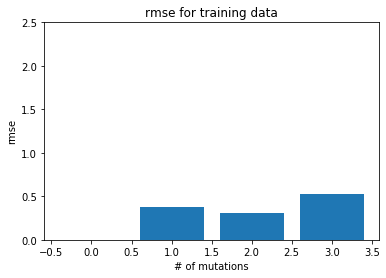

In [14]:
train_pearson_list = []
for n_m in range(np.min(train_df['num_mutations']),np.max(train_df['num_mutations'])+1):
    pred_y = y_train_linear_pred[train_df['num_mutations'] == n_m]
    true_y = np.array(train_y)[train_df['num_mutations'] == n_m]
    if(len(pred_y)>1):
        train_pearson_list.append(mean_squared_error(pred_y, true_y))
    else:
        train_pearson_list.append(0)
plt.bar(np.arange(np.min(train_df['num_mutations']),np.max(train_df['num_mutations'])+1), train_pearson_list)
plt.title('rmse for training data')
plt.ylim([0,2.5])
plt.xlabel('# of mutations')
plt.ylabel('rmse')

Text(0, 0.5, 'rmse')

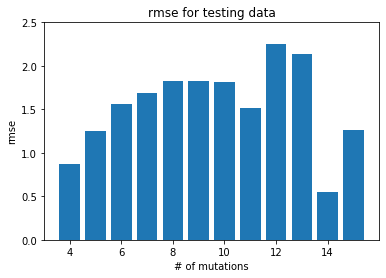

In [15]:
test_pearson_list = []
for n_m in range(np.min(test_df['num_mutations']),np.max(test_df['num_mutations'])+1):
    pred_y = y_test_linear_pred[test_df['num_mutations'] == n_m]
    true_y = np.array(test_y)[test_df['num_mutations'] == n_m]
    if(len(pred_y)>1):
        test_pearson_list.append(mean_squared_error(pred_y, true_y))
    else:
        test_pearson_list.append(0)
plt.bar(np.arange(np.min(test_df['num_mutations']),np.max(test_df['num_mutations'])+1), test_pearson_list)
plt.ylim([0,2.5])
plt.title('rmse for testing data')
plt.xlabel('# of mutations')
plt.ylabel('rmse')

# MIMO model

For the three inputs (shape: sequence_length(237)  * number of aa (21)), they are first seperately processed by three embeding layers such that the output would be three tensors of shape (sequence_length(237)  * embedding_dimension(128)). This is the MI part of the model.

Then the three tensors are process by the same CNN module. This model has three CNNs separated by ReLUs, with increasing kernel size and filter number. The architecture of the CNN module is copied from DeepDTA, a model I've tested during my internship. 

The output of the CNN module for the three input sequences are three vectors with 96 elements (96*1, 96 is the number of filters for the last CNN layer).Then these three 96*1 vectors are seperately processed by three dense layer to get three outputs. This is the MO part of the model.

The output is the prediciton of log fluorescence. 

In [16]:
class ProtMIMO_CNN(nn.Module):
    def __init__(self, label_len, embed_dim, max_len, cnn_channels, cnn_kernels):
        super().__init__()
        
        # independent input embedding layers
        self.Embed0 = nn.Embedding(num_embeddings=label_len,embedding_dim=embed_dim)
        self.Embed1 = nn.Embedding(num_embeddings=label_len,embedding_dim=embed_dim)
        self.Embed2 = nn.Embedding(num_embeddings=label_len,embedding_dim=embed_dim)
        
        # shared CNN layers
        # The CNN architecture and hyperparameters were used from DeepDTA(https://arxiv.org/pdf/1801.10193.pdf)
        self.Conv0 = nn.Conv1d(in_channels=embed_dim, out_channels=cnn_channels[0], kernel_size=cnn_kernels[0], padding=0)
        self.Conv1 = nn.Conv1d(in_channels=cnn_channels[0], out_channels=cnn_channels[1], kernel_size=cnn_kernels[1], padding=0)
        self.Conv2 = nn.Conv1d(in_channels=cnn_channels[1], out_channels=cnn_channels[2], kernel_size=cnn_kernels[2], padding=0)
        self.Maxpool = nn.MaxPool1d(max_len-cnn_kernels[0]-cnn_kernels[1]-cnn_kernels[2]+3)
        self.ReLu = nn.ReLU()
        
        # independent output fully connected layers
        self.fc0 = nn.Linear(cnn_channels[2],1)
        self.fc1 = nn.Linear(cnn_channels[2],1)
        self.fc2 = nn.Linear(cnn_channels[2],1)
    
    def forward(self, pro0, pro1, pro2):
        
        x0 = self.Embed0(pro0)
        x1 = self.Embed1(pro1)
        x2 = self.Embed2(pro2)
        
        xs = [x0,x1,x2]
        ys = []
        for x in xs:
            x = x.permute(0,2,1)
            x = self.Conv0(x)
            x = self.ReLu(x)
            x = self.Conv1(x)
            x = self.ReLu(x)
            x = self.Conv2(x)
            x = self.ReLu(x)
            x = self.Maxpool(x).squeeze(2)
            ys.append(x)
        
        y0 = self.fc0(ys[0]).squeeze(1)
        y1 = self.fc1(ys[1]).squeeze(1)
        y2 = self.fc2(ys[2]).squeeze(1)
        
        return [y0,y1,y2]

# DataLoaders
For training, I shuffled the training data for three times to make three inputs. For validation and testing, I just take the original data, and fed the input to MIMO for three times.

Because of the shuffling, each epoch of MIMO will be equivalent to three epochs of "single input single output" network. 

In [17]:
class MyTrainDataset(Dataset):

    def __init__(self, df0):
        super().__init__()
        
        seq_label = []
        for i,x in df0.iterrows():
            seq_label.append(convert_seq_to_label(x['primary'], GFP_ALPHABET))
        df0['seq_label'] = seq_label
        
        # shuffle the original data from to get the second and the third input
        df1 = df0.sample(frac=1)
        df2 = df0.sample(frac=1)
        
        self.pro0 = torch.from_numpy(np.asarray(list(df0['seq_label']),dtype=np.int64))
        self.pro1 = torch.from_numpy(np.asarray(list(df1['seq_label']),dtype=np.int64))
        self.pro2 = torch.from_numpy(np.asarray(list(df2['seq_label']),dtype=np.int64))
        
        self.y0 = torch.Tensor(list(df0['log_fluorescence']))
        self.y1 = torch.Tensor(list(df1['log_fluorescence']))
        self.y2 = torch.Tensor(list(df2['log_fluorescence']))


    def __len__(self):
        return len(self.y0)
    
    
    def __getitem__(self, idx):
        sample = {'pro0': self.pro0[idx], 'y0': self.y0[idx], 
                  'pro1': self.pro1[idx], 'y1': self.y1[idx],
                  'pro2': self.pro2[idx], 'y2': self.y2[idx],}

        return sample
    

In [18]:
class MyTestDataset(Dataset):
    # no need to shuffle. Just feed the same input sequence for three times

    def __init__(self, df): 
        super().__init__()
        
        seq_label = []
        for i,x in df.iterrows():
            seq_label.append(convert_seq_to_label(x['primary'], GFP_ALPHABET))
        
        self.pro = torch.from_numpy(np.asarray(seq_label,dtype=np.int64))
        
        self.y = torch.Tensor(list(df['log_fluorescence']))

    def __len__(self):
        return len(self.y)
    
    
    def __getitem__(self, idx):
        sample = {'pro': self.pro[idx], 'y': self.y[idx]}

        return sample

# Train model

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        y0, y1, y2 = model(data['pro0'].to(device), data['pro1'].to(device), data['pro2'].to(device))
        output = torch.concat((y0,y1,y2)).to(device)
        loss = loss_fn(output, torch.concat((data['y0'], data['y1'], data['y2'])).float().to(device))
        loss.backward()
        optimizer.step()

In [20]:
def predict(model, device, loader, return_std=False):
    # return the std of the three predicitons when needed

    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    model.eval()
    preds = torch.Tensor()
    trues = torch.Tensor()
    pred_stds = torch.Tensor()
    with torch.no_grad():
        for data in loader:
            #data = data
            y0, y1, y2 = model(data['pro'].to(device), data['pro'].to(device), data['pro'].to(device))
            output = (y0+y1+y2)/3
            preds = torch.cat((preds, output.cpu()), 0)
            trues = torch.cat((trues, data['y'].cpu()), 0)
            if(return_std):
              stds = torch.std(torch.stack((y0,y1,y2)),dim=0)
              pred_stds = torch.cat((pred_stds, stds.cpu()), 0)
    if(return_std):
      return trues.numpy().flatten(), preds.numpy().flatten(), pred_stds.numpy().flatten()
    else:
      return trues.numpy().flatten(),preds.numpy().flatten()

In [21]:
# The CNN architecture and hyperparameters were used from DeepDTA(https://arxiv.org/pdf/1801.10193.pdf)
model = ProtMIMO_CNN(label_len=len(GFP_ALPHABET), 
                     embed_dim=128, 
                     max_len=237, 
                     cnn_channels=[32,64,96], 
                     cnn_kernels=[4,8,12])

In [22]:
BATCH_SIZE = 50
LR = 1e-4
L2_weight = 1e-5    # L2 regularization
NUM_EPOCHS = 33     # Since we have 3 inputs, 33 epochs is equivalent to 100 epochs for single-in-single-out NNs

In [23]:
train_data = MyTrainDataset(train_df)
val_data = MyTestDataset(val_df)
test_data = MyTestDataset(test_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
cuda_name = "cuda:0"
device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
model = model.to(device)
df_results = pd.DataFrame(columns = ['# of epoch', 'mse', 'pearson correlation', 'spearman rho'])
torch.save(model.state_dict(), '/content/drive/MyDrive/test_prot_mimo/checkpoints/model_checkpoint.pt')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
best_mse = 1000
best_epoch = -1
for epoch in range(NUM_EPOCHS):
    train(model, device, train_loader, optimizer, epoch+1)
    torch.save(model.state_dict(), '/content/drive/MyDrive/test_prot_mimo/results/model_epoch'+str(epoch+1)+'.pt')
    T,P = predict(model, device, val_loader)
    rmse = mean_squared_error(T, P)
    pearson_correlation = pearsonr(T, P)
    spearman_rho = spearmanr(T,P)
    df_results.loc[len(df_results)] = [epoch+1, rmse, pearson_correlation, spearman_rho]
    if rmse<best_mse:
        torch.save(model.state_dict(), '/content/drive/MyDrive/test_prot_mimo/results/best_model.pt')
        best_epoch = epoch+1
        best_mse = rmse
        print('rmse improved at epoch ', best_epoch, '; best_mse:', best_mse)
    else:
        print('current rmse:',rmse,'No improvement since epoch ', best_epoch, '; best_mse:', best_mse)
df_results.to_csv('/content/drive/MyDrive/test_prot_mimo/results/training_history.csv')

Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  1 ; best_mse: 0.68280923
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  2 ; best_mse: 0.6667901
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  3 ; best_mse: 0.63687545
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  4 ; best_mse: 0.5637583
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  5 ; best_mse: 0.43144494
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  6 ; best_mse: 0.31548014
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  7 ; best_mse: 0.2516071
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  8 ; best_mse: 0.21679221
Training on 21446 samples...
Make prediction for 5362 samples...
rmse improved at epoch  9 

# Training history
I found after training for 33 epoches (equivalently 100 epoches for vanilla networks), the validation rmse is lowered to ~0.1, significantly better than the linear regression model.

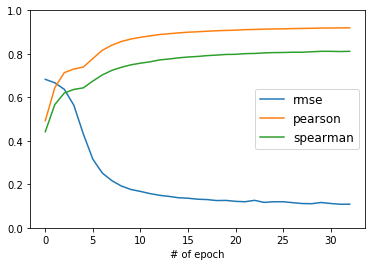

In [26]:
df_results = pd.read_csv('/content/drive/MyDrive/test_prot_mimo/results/training_history.csv')
rmse_hist = list(df_results['mse'])
pearson_correlation_hist = list(df_results['pearson correlation'])
pearson_correlation_hist = [float(x.split(',')[0][1:]) for x in pearson_correlation_hist]
spearman_rho_hist = list(df_results['spearman rho'])
spearman_rho_hist = [float(x.split(',')[0].split('=')[-1]) for x in spearman_rho_hist]
plt.plot(rmse_hist)
plt.plot(pearson_correlation_hist)
plt.plot(spearman_rho_hist)
plt.ylim([0,1])
plt.xlabel('# of epoch')
plt.legend(['rmse','pearson','spearman'], fontsize=12)

# Prediction on testing set
The model with the lowest rmse was used to make predictions on the testing set. The rmse of the testing data prediction is 0.42, lower than the std of the testing data and the linear regression model, although it is much bigger than on the training/validation set. 

I found that the MIMO model predicted the sequence with high fluorescence (>3) pretty well. However, for the low fluorescence datapoints (<2) the model didn't perform well. Possibly the reason is that there are not many data points of low flourescence intensity in the training set. 

In [27]:
model_best = model
model_best.load_state_dict(torch.load('/content/drive/MyDrive/test_prot_mimo/results/best_model.pt'))
T, P, Pstds = predict(model_best, device, test_loader, return_std=True)
Tv, Pv, Pvstds = predict(model_best, device, val_loader, return_std=True)
test_model_mse = mean_squared_error(T, P)
test_model_pearson = pearsonr(T, P)[0]
test_model_spearmanr = spearmanr(T, P).correlation   
val_model_mse = mean_squared_error(Tv, Pv)
val_model_pearson = pearsonr(Tv, Pv)[0]
val_model_spearmanr = spearmanr(Tv, Pv).correlation   

Make prediction for 27217 samples...
Make prediction for 5362 samples...


In [28]:
print('validation data: mse, pearson correltion, Spearman Rho:')
print(np.round(val_model_mse,2), np.round(val_model_pearson,2), np.round(val_model_spearmanr,2))
print('test data: mse, pearson correltion, Spearman Rho:')
print(np.round(test_model_mse,2), np.round(test_model_pearson,2), np.round(test_model_spearmanr,2))

validation data: mse, pearson correltion, Spearman Rho:
0.11 0.92 0.81
test data: mse, pearson correltion, Spearman Rho:
0.42 0.81 0.67


Text(0, 0.5, 'prediction')

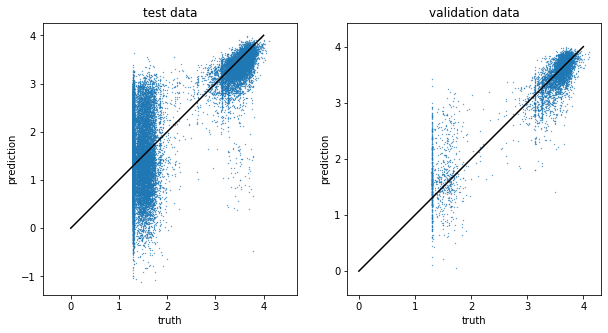

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('test data')
plt.scatter(T, P, s=0.1)
plt.plot([0,4],[0,4],'k')
plt.axis('equal')
plt.xlabel('truth')
plt.ylabel('prediction')


plt.subplot(122)
plt.title('validation data')
plt.scatter(Tv, Pv, s=0.1)
plt.plot([0,4],[0,4],'k')
plt.axis('equal')
plt.xlabel('truth')
plt.ylabel('prediction')


# Predicting the uncertainty
According to the authors of MIMO, they claimed that the model could provide some uncertainty insights as the model could give three outputs for one data point. Thus, I seek for correlations between the std of the three predictions and the error between the prediciton and the truth. In other words, if the model predicts a data point inaccurately, it should know the uncertainty of its prediction by using the information of the three outpus. Indicated by pearson correlation, there is only a weak but still, positive correlation.

pearson correlation between squared error and prediction std: 0.16


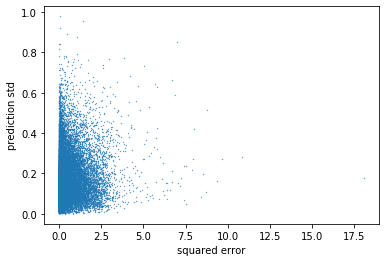

In [33]:
plt.scatter((T-P)**2, Pstds,s=0.1)
plt.xlabel('squared error')
plt.ylabel('prediction std')
tmp1 = pearsonr((T-P)**2, Pstds)
print('pearson correlation between squared error and prediction std:', np.round(tmp1[0],2))

# Evaluating the model prediciton for different mutation numbers
Since the model was fitted to low mutation numbers (<=3), the model predicted better on the testing datapoints with small mutation numbers. 

Text(0, 0.5, 'rmse')

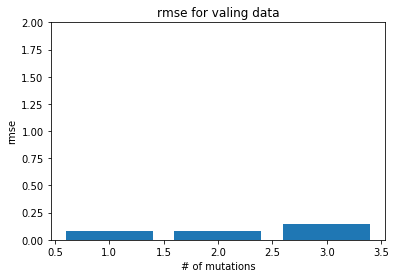

In [37]:
val_mse_list = []
for n_m in range(np.min(val_df['num_mutations']),np.max(val_df['num_mutations'])+1):
    pred_y = Pv[val_df['num_mutations'] == n_m]
    true_y = np.array(val_y)[val_df['num_mutations'] == n_m]
    if(len(pred_y)>1):
        val_mse_list.append(mean_squared_error(pred_y, true_y))
    else:
        val_mse_list.append(0)
plt.bar(np.arange(np.min(val_df['num_mutations']),np.max(val_df['num_mutations'])+1), val_mse_list)
plt.title('rmse for valing data')
plt.ylim([0,2])
plt.xlabel('# of mutations')
plt.ylabel('rmse')

Text(0, 0.5, 'rmse')

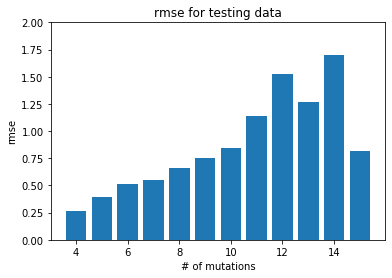

In [36]:
test_mse_list = []
for n_m in range(np.min(test_df['num_mutations']),np.max(test_df['num_mutations'])+1):
    pred_y = P[test_df['num_mutations'] == n_m]
    true_y = np.array(test_y)[test_df['num_mutations'] == n_m]
    if(len(pred_y)>1):
        test_mse_list.append(mean_squared_error(pred_y, true_y))
    else:
        test_mse_list.append(0)
plt.bar(np.arange(np.min(test_df['num_mutations']),np.max(test_df['num_mutations'])+1), test_mse_list)
plt.title('rmse for testing data')
plt.ylim([0,2])
plt.xlabel('# of mutations')
plt.ylabel('rmse')

# Compare to other models
For the tranditional regression methods, I developed another two linear regression models. The difference is the input. For the two new models, in addition to the 237 elements each representing an amino acids, I added (1) the square of each elements $x_i^2$, and (2) the cross product of neighbouring elements $x_i*x_{i+1}$, respectively to the input vector. Thus, the input vector would have twice the length of the sequence lenght. 

The three linear regression models all predicted worse than the MIMO model

In [38]:
train_seq_label_a1 = []
test_seq_label_a1 = []
for i,l in enumerate(train_seq_label):
    l = l + list(np.array(l)**2)
    train_seq_label_a1.append(l)
for i,l in enumerate(test_seq_label):
    l = l + list(np.array(l)**2)
    test_seq_label_a1.append(l)

model_linear2 = LinearRegression().fit(np.array(train_seq_label_a1), np.array(train_y))
y_test_linear2_pred = model_linear2.predict(test_seq_label_a1)
test2_mse = mean_squared_error(test_y, y_test_linear2_pred)
test2_pearson = pearsonr(test_y, y_test_linear2_pred)[0]
test2_spearmanr = spearmanr(test_y, y_test_linear2_pred).correlation    

In [39]:
train_seq_label_a2 = []
test_seq_label_a2 = []
for i,l in enumerate(train_seq_label):
    l = l + list(np.array(l[:-1])*np.array(l[1:]))
    train_seq_label_a2.append(l)
for i,l in enumerate(test_seq_label):
    l = l + list(np.array(l[:-1])*np.array(l[1:]))
    test_seq_label_a2.append(l)

model_linear3 = LinearRegression().fit(np.array(train_seq_label_a2), np.array(train_y))
y_test_linear3_pred = model_linear3.predict(test_seq_label_a2)
test3_mse = mean_squared_error(test_y, y_test_linear3_pred)
test3_pearson = pearsonr(test_y, y_test_linear3_pred)[0]
test3_spearmanr = spearmanr(test_y, y_test_linear3_pred).correlation    

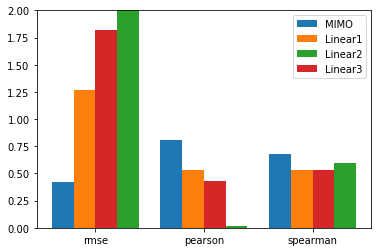

In [41]:
X = ['rmse','pearson','spearman']
mimo_results = [test_model_mse, test_model_pearson, test_model_spearmanr]
lin1 = [test_mse, test_pearson, test_spearmanr]
lin2 = [test2_mse, test2_pearson, test2_spearmanr]
lin3 = [test3_mse, test3_pearson, test3_spearmanr]
  
X_axis = np.arange(len(X))

wid = 0.1
plt.bar(X_axis - wid*3, mimo_results, wid*2, label = 'MIMO')
plt.bar(X_axis - wid*1, lin1, wid*2, label = 'Linear1')
plt.bar(X_axis + wid*3, lin2, wid*2, label = 'Linear2')
plt.bar(X_axis + wid*1, lin3, wid*2, label = 'Linear3')
  
plt.xticks(X_axis, X)
plt.ylim([0,2])
plt.legend()